# Email Classification: Spam vs. Ham with Various Preprocessing Techniques


**Data Preparation**

I downloaded the data from the following links: [Spam Email Dataset](https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset) and [Spam Mails Dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset).


We will begin by inspecting the dataset and removing duplicate values and any NaN entries.

In [233]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/trancite/Desktop/Spam/archive/emails.csv")
original_len = len(df)
df = df.dropna()
df = df.drop_duplicates()
print(len(df))
end_len = len(df)

print(f'There were {original_len-end_len} "corrupted" rows')

5728
5728
5695
There were 33 "corrupted" rows


In [234]:
# Class for cleaning text
import re
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

class TextCleaner:
    def __init__(self):
        # Initialize stopwords and stemmer
        self.stop_words = set(stopwords.words('english'))  # Set of common English stop words to be removed
        self.stemmer = PorterStemmer()  # Stemmer to reduce words to their root form

    def clean(self, text):
        # Convert text to lowercase to ensure uniformity
        text = text.lower()
        
        # Normalize text to ensure consistent character representation
        text = unicodedata.normalize('NFKD', text)
        
        # Replace multiple whitespace characters with a single space
        text = re.sub(r'\s+', ' ', text)
        
        # Replace URLs with the placeholder 'U'
        text = re.sub(r'http[s]?://\S+', ' U ', text)
        
        # Remove HTML tags from the text
        text = re.sub(r'<[^>]+>', '', text)
        
        # Replace numerical digits with the placeholder 'DIG'
        text = re.sub(r'\d+', ' DIG ', text)
        
        # Remove punctuation characters
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove stop words from the text
        text = ' '.join(word for word in text.split() if word not in self.stop_words)
        
        # Apply stemming to reduce words to their root form
        text = ' '.join(self.stemmer.stem(word) for word in text.split())
        
        return text

#auxiliar function for removing the firs word. It is not included in the TextCleaner class because some raw text might not need it
def remove_first_word(text):
        # Split text into words and remove the first word
        words = text.split()
        if len(words) > 1:
            return ' '.join(words[1:])
        return ''  # Return empty string if there's only one word

**Brief Statistical Analysis**

Next, we will count the number of instances for each label.

In [236]:
spam_instances = df.groupby(['spam']).count()
print(spam_instances)


      text
spam      
0     4327
1     1368


It is clearly an imbalanced dataset

In [238]:
print(f'The {1368*100/(4327+1368)}% of the instances are spam')

The 24.021071115013168% of the instances are spam


Let's visualize this difference using a graph.

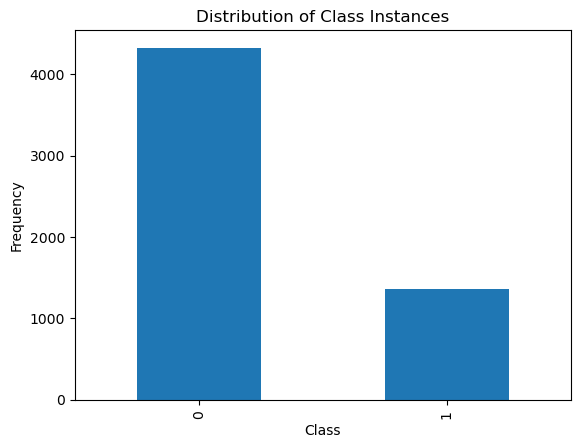

In [239]:
import matplotlib.pyplot as plt
class_counts = df['spam'].value_counts()

class_counts.plot(kind='bar')
plt.title('Distribution of Class Instances')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

We will create a baseline model that assumes every instance belongs to the "ham" class and assess its performance. This will provide insight into the expected performance of our final model.



In [240]:
def silly_model(whatever):
    return 0

print(f'This model will have an accuracy of {4327/(4327+1368)}, so we need to improve this apparently good score')

This model will have an accuracy of 0.7597892888498683, so we need to improve this apparently good score


We will evaluate additional metrics for this model. If they result in lower values, they will provide useful insights.

In [241]:
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, f1_score, confusion_matrix
y = np.array(df['spam']).astype(int)
silly_predictions = np.full(np.shape(y), 0)
print(classification_report(y, silly_predictions, zero_division=0))


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4327
           1       0.00      0.00      0.00      1368

    accuracy                           0.76      5695
   macro avg       0.38      0.50      0.43      5695
weighted avg       0.58      0.76      0.66      5695



All of them in the 1 label are 0, and the other ones are not too good. This tell us that we need to improve all this scores

We will display a matrix and a visualization representing the model's performance. The matrix, called the confusion matrix, shows the true labels as rows and the predicted labels as columns.


Confusion Matrix:
[[4327    0]
 [1368    0]]





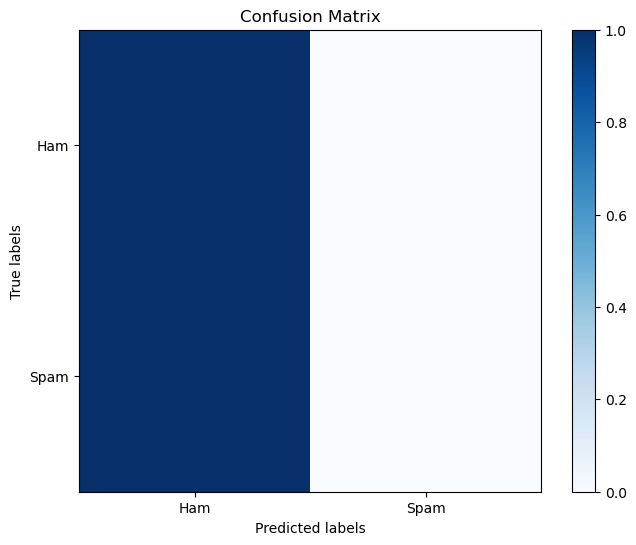

In [242]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y, silly_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print("\n\n")
# Normalize the confusion matrix
conf_matrix = conf_matrix.astype(float)
row_sums = np.maximum(conf_matrix.sum(axis=1), 1)
conf_matrix /= row_sums[:, np.newaxis]

# Show the normalized confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')  
plt.title('Confusion Matrix')
plt.colorbar()  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam']) 
plt.yticks(ticks=[0, 1], labels=['Ham', 'Spam'])  
plt.show()


Now we clean all the text emails, this can take some time

In [243]:
# Remove the first word (Subject:) from each email text
df['text'] = df['text'].apply(remove_first_word)

# Initialize the TextCleaner object for text preprocessing
cleaner = TextCleaner()

# Apply the text cleaning process to each email and save the processed texts in a new column
df['cleaned_mails'] = df['text'].apply(cleaner.clean)

Ensure the changes have done their job

In [244]:
df.head()

,text,spam,cleaned_mails
0,naturally irresistible your corporate identity...,1,natur irresist corpor ident lt realli hard rec...
1,the stock trading gunslinger fanny is merrill ...,1,stock trade gunsling fanni merril muzo colza a...
2,unbelievable new homes made easy im wanting to...,1,unbeliev new home made easi im want show homeo...
3,4 color printing special request additional in...,1,dig color print special request addit inform c...
4,"do not have money , get software cds from here...",1,money get softwar cd softwar compat great grow...


**Clustering Analysis: Unsupervised Learning**

First, we load the tools needed for text preprocessing. Each tool employs a different approach, ranging from tokenizing text based on certain lengths to using hash functions.


In [245]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

# Initialize the text preprocessing tools with specific parameters to ensure efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.8)
count_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3), min_df=3)
hashing_vectorizer = HashingVectorizer(n_features=1000)



Here, we define a function that takes a preprocessing tool as an argument and displays a graph of its performance. We will use the Silhouette metric, which is commonly used in this context. Other metrics, such as inertia, typically do not perform as well as Silhouette.


In [255]:
def performance_cluster(text_tool):
    
    # Transform the cleaned emails using the provided text preprocessing tool
    X_for_performance = text_tool.fit_transform(df['cleaned_mails'])
    
    points_X = []  # List to store the number of clusters
    points_Y = []  # List to store the corresponding silhouette scores
    
    # Evaluate KMeans clustering performance for a range of cluster numbers
    for n in range(2, 20):
        kmeans = KMeans(n_clusters=n)  # Initialize the KMeans model with n clusters
        kmeans.fit_predict(X_for_performance)  # Fit the model to the data; no data leakage as KMeans is unsupervised
        # Compute the silhouette score for the current clustering and store it
        points_Y.append(silhouette_score(X_for_performance, kmeans.labels_))
        points_X.append(n)
    
    plt.plot(points_X, points_Y, marker='o')  
    plt.title("Silhouette Score vs Number of Clusters")  
    plt.xlabel("Number of Clusters") 
    plt.ylabel("Silhouette Score")  
    plt.grid(True)  
    plt.show()




Note: This function runs the KMeans algorithm 18 times (once for each cluster count).
By default in scikit-learn, KMeans runs the algorithm 10 times with different centroid initializations to ensure that the result is not dependent on the initial placement of centroids. 
This may result in a longer runtime due to repeated fitting of the model.

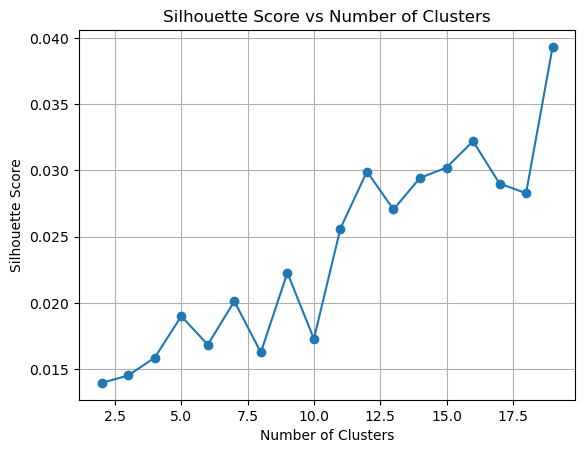

In [256]:
#Graph of tfidf_vectorizer tool
performance_cluster(tfidf_vectorizer)

Although it is clear that there is an unexpected peak at 18 clusters, the values on the y-axis are extremely low. This indicates that these clusters do not fit well with the dataset.

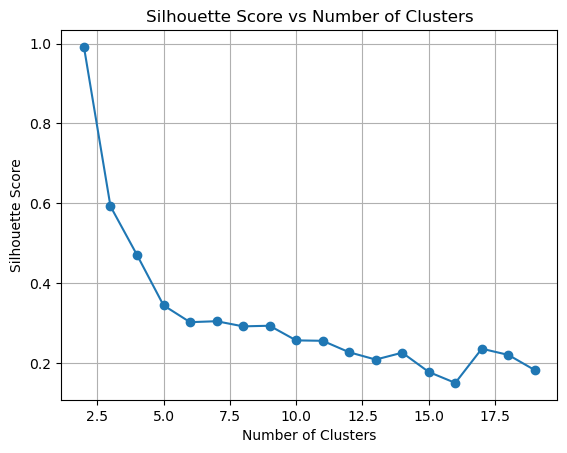

In [248]:
#Graph of count_vectorizer tool
performance_cluster(count_vectorizer)

The high peak at two clusters seems suspicious. We will analyze it further in the following cells.


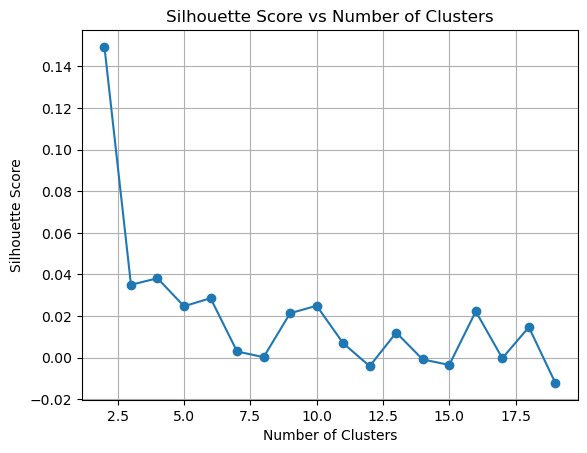

In [249]:
#Graph of hashing_vectorizer tool
performance_cluster(hashing_vectorizer)

This one apparently achieves a good performance (lower than the previous one) at two clusters. 

The tfidf_vectorizer performed terribly; we will not consider it for this process.

Let's see how the other methods performed compared to the actual Spam-Ham labels.


**Count_vectorizer**

In [263]:
# Store the corresponding labels for X in the variable Y
Y = np.array(df['spam']).astype(int)

In [264]:
#count_vectorizer
print("Count Vectorizer")
X_count = count_vectorizer.fit_transform(df['cleaned_mails'])
kmeans = KMeans(n_clusters=2)
y_pred_vect = kmeans.fit_predict(X_count)
print(classification_report(Y, y_pred_vect))




Count Vectorizer
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4327
           1       0.24      1.00      0.39      1368

    accuracy                           0.24      5695
   macro avg       0.62      0.50      0.19      5695
weighted avg       0.82      0.24      0.09      5695



It seems that the model attempted the same strategy as our silly model! This is interesting but does not provide any useful information for us.


**Hashing vectorizer**

In [266]:
#Hashing vectorizer
print("Hashing Vectorizer")
X_hashing = hashing_vectorizer.fit_transform(df['cleaned_mails'])
kmeans = KMeans(n_clusters=2)
y_pred_hash = kmeans.fit_predict(X_hashing)
print(classification_report(Y, y_pred_hash, zero_division=0))


Hashing Vectorizer
              precision    recall  f1-score   support

           0       0.61      0.32      0.42      4327
           1       0.14      0.36      0.20      1368

    accuracy                           0.33      5695
   macro avg       0.38      0.34      0.31      5695
weighted avg       0.50      0.33      0.37      5695



This is promising! This model managed to classify spam emails separately from ham emails, more or less, without considering the labels! This confirms that this preprocessing model can "capture" the essence of the problem. I am aware that the metrics were bad, but this is still surprising considering that the model worked without any labels


**Model Tuning**

We will evaluate five different classification algorithms and determine which performs best with various parameters. Interestingly, we will use tfidf_vectorizer for this process, despite its poor performance in the previous analysis. This might seem surprising, but do not be misled by earlier results. Although TfidfVectorizer performed poorly with KMeans clustering, it has shown outstanding performance in this section. Among the three metrics I computed, TfidfVectorizer yielded the best results. 

**WARNING**: This can take several minutes, at least on my slow computer it did. Moreover, it may produce some warnings because some tools can cause unusual effects during scoring. If this happens to you, you can change the score to 'accuracy' or ignore these warnings.

In [269]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Sample DataFrame


# Split data
X_train, X_test, Y_train, Y_test = train_test_split(df['cleaned_mails'], df['spam'], test_size=0.2, random_state=42)

# Define the models and parameter grids
models = {
    'svc': SVC(probability=True),
    'extra_trees': ExtraTreesClassifier(n_jobs=-1, random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier(n_jobs=-1, random_state=42),
    'k_neighbors': KNeighborsClassifier()
}

param_grids = {
    'svc': {
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3],  
        'svc__coef0': [0, 1]    
    },
    'extra_trees': {
        'extra_trees__n_estimators': [50, 100, 200],
        'extra_trees__max_features': ['auto', 'sqrt', 'log2'],
        'extra_trees__min_samples_split': [2, 5, 10]
    },
    'logistic_regression': {
        'logistic_regression__penalty': ['l2'],
        'logistic_regression__C': [0.1, 1, 10],
        'logistic_regression__solver': ['liblinear', 'saga']
    },
    'random_forest': {
        'random_forest__n_estimators': [50, 100, 200],
        'random_forest__max_features': ['auto', 'sqrt', 'log2'],
        'random_forest__min_samples_split': [2, 5, 10]
    },
    'k_neighbors': {
        'k_neighbors__n_neighbors': [3, 5, 7],
        'k_neighbors__weights': ['uniform', 'distance']
    }
}

# Define the pipelines and GridSearchCV for each model
results = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Add preprocessing steps here if needed
        (model_name, model)
    ])
    
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1, scoring='f1', verbose=3)
    grid_search.fit(X_train, Y_train)
    
    results[model_name] = grid_search.best_params_, grid_search.best_score_

# Print the results
for model_name, (best_params, best_score) in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {best_score:.4f}")
    print()


/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/trancite/anaconda3/envs/cachine/l

Model: svc
Best Parameters: {'svc__C': 10, 'svc__coef0': 0, 'svc__degree': 2, 'svc__kernel': 'linear'}
Best Score: 0.9817

Model: extra_trees
Best Parameters: {'extra_trees__max_features': 'sqrt', 'extra_trees__min_samples_split': 2, 'extra_trees__n_estimators': 200}
Best Score: 0.9344

Model: logistic_regression
Best Parameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'saga'}
Best Score: 0.9753

Model: random_forest
Best Parameters: {'random_forest__max_features': 'sqrt', 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 200}
Best Score: 0.9394

Model: k_neighbors
Best Parameters: {'k_neighbors__n_neighbors': 3, 'k_neighbors__weights': 'distance'}
Best Score: 0.9304



My results:

Model: svc
Best Parameters: {'svc__C': 10, 'svc__coef0': 0, 'svc__degree': 2, 'svc__kernel': 'linear'}
Best Score: 0.9817

Model: extra_trees
Best Parameters: {'extra_trees__max_features': 'sqrt', 'extra_trees__min_samples_split': 2, 'extra_trees__n_estimators': 200}
Best Score: 0.9344

Model: logistic_regression
Best Parameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'saga'}
Best Score: 0.9753

Model: random_forest
Best Parameters: {'random_forest__max_features': 'sqrt', 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 200}
Best Score: 0.9394

Model: k_neighbors
Best Parameters: {'k_neighbors__n_neighbors': 3, 'k_neighbors__weights': 'distance'}
Best Score: 0.9304

Now, with these parameters, we will train and evaluate the algorithms, but this time we will fine-tune the preprocessing tool. This is for two main reasons:

    1. There might be a preprocessing tool that performs better with some algorithms.
    2. We will use three algorithms, each with a different preprocessing tool, to gain a more sophisticated insight into the problem.

In [270]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, average='weighted')

X_train, X_test, Y_train, Y_test = train_test_split(df['cleaned_mails'], df['spam'], test_size=0.2, random_state=42)

best_models = {
    'svc': SVC(probability=True, C=1, coef0=0, degree=2, kernel='linear'),
    'extra_trees': ExtraTreesClassifier(n_jobs=-1, random_state=42, max_features='sqrt', min_samples_split=2, n_estimators=200),
    'logistic_regression': LogisticRegression(max_iter=1000, C=10, penalty='l2', solver='saga'),
    'random_forest': RandomForestClassifier(n_jobs=-1, random_state=42, max_features='sqrt', min_samples_split=2, n_estimators=200),
    'k_neighbors': KNeighborsClassifier(n_neighbors=3, weights='distance')
}

preprocessors = {
    'tfidf': tfidf_vectorizer,
    'count': count_vectorizer,
    'hashing': hashing_vectorizer
}

# Define a parameter grid with no additional parameters (fixed parameters)
param_grids = {
    'svc': {},
    'extra_trees': {},
    'logistic_regression': {},
    'random_forest': {},
    'k_neighbors': {}
}

# Define f1_score as the scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Run GridSearchCV for each combination of preprocessor and model
results = {}
for preprocessor_name, preprocessor in preprocessors.items():
    for model_name, model in best_models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            (model_name, model)
        ])
        
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=f1_scorer, verbose=2)
        grid_search.fit(X_train, Y_train)
        
        results[(preprocessor_name, model_name)] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }

# Print the results
for (preprocessor_name, model_name), result in results.items():
    print(f"Preprocessor: {preprocessor_name}, Model: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best F1 Score: {result['best_score']:.4f}")
    print()



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trancite/anaconda3/envs/cachine/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Preprocessor: tfidf, Model: svc
Best Parameters: {}
Best F1 Score: 0.9838

Preprocessor: tfidf, Model: extra_trees
Best Parameters: {}
Best F1 Score: 0.9841

Preprocessor: tfidf, Model: logistic_regression
Best Parameters: {}
Best F1 Score: 0.9855

Preprocessor: tfidf, Model: random_forest
Best Parameters: {}
Best F1 Score: 0.9816

Preprocessor: tfidf, Model: k_neighbors
Best Parameters: {}
Best F1 Score: 0.7806

Preprocessor: count, Model: svc
Best Parameters: {}
Best F1 Score: 0.9731

Preprocessor: count, Model: extra_trees
Best Parameters: {}
Best F1 Score: 0.9812

Preprocessor

**My results**

Preprocessor: tfidf, Model: svc
Best F1 Score: 0.9838

Preprocessor: tfidf, Model: extra_trees
Best F1 Score: 0.9841

Preprocessor: tfidf, Model: logistic_regression
Best F1 Score: 0.9855

Preprocessor: tfidf, Model: random_forest
Best F1 Score: 0.9816

Preprocessor: tfidf, Model: k_neighbors
Best F1 Score: 0.7806

Preprocessor: count, Model: svc
Best F1 Score: 0.9731

Preprocessor: count, Model: extra_trees
Best F1 Score: 0.9812

Preprocessor: count, Model: logistic_regression
Best F1 Score: 0.9241

Preprocessor: count, Model: random_forest
Best F1 Score: 0.9820

Preprocessor: count, Model: k_neighbors
Best F1 Score: 0.8897

Preprocessor: hashing, Model: svc
Best F1 Score: 0.9710

Preprocessor: hashing, Model: extra_trees
Best F1 Score: 0.9626

Preprocessor: hashing, Model: logistic_regression
Best F1 Score: 0.9758

Preprocessor: hashing, Model: random_forest
Best F1 Score: 0.9738

Preprocessor: hashing, Model: k_neighbors
Best F1 Score: 0.9501

**Ensembling the models**

We need to choose three algorithms and assign a different preprocessing tool to each one. We do not want to select both Extra Trees Classifier and Random Forest Classifier because they are quite similar, and the goal is to achieve diverse insights. 
Therefore, the final selection will be:

    Logistic Regression with tfidf_vectorizer
    Random Forest Classifier with count_vectorizer
    KNeighbors Classifier with hashing_vectorizer

To ensemble the models, we will use the Voting Classifier method. This approach is both simple and effective. It aggregates the predictions from the three models and selects the most frequent class. Given that there are only three models, this might initially seem limited since there are only nine possible combinations. Therefore, we will use the 'soft' mode, which instead of selecting the most frequent class, sums the probabilities from each model and chooses the class with the highest probability.

In [271]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Define pipelines for each algorithm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Define pipelines for each algorithm

# Pipeline for Logistic Regression with TF-IDF vectorizer
pipeline1 = Pipeline([
    ('preproc', tfidf_vectorizer),  #
    ('log', LogisticRegression(max_iter=1000, C=10, penalty='l2', solver='liblinear'))  #
])

# Pipeline for Random Forest with Count Vectorizer
pipeline2 = Pipeline([
    ('preproc', count_vectorizer),  
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42, max_features='sqrt', min_samples_split=5, n_estimators=200))  
])

# Pipeline for K-Neighbors Classifier with Hashing Vectorizer
pipeline3 = Pipeline([
    ('preproc', hashing_vectorizer),  
    ('kn', KNeighborsClassifier(n_neighbors=3, weights='distance'))  
])

# Define the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[  # List of models to be used in the voting classifier
        ('logistic', pipeline1),  
        ('rf', pipeline2),        
        ('knn', pipeline3)        
    ],
    voting='soft'  # Use soft voting 
)


# Split data
X_train, X_val, Y_train, Y_val = train_test_split(df['cleaned_mails'], df['spam'], test_size=0.2, random_state=100)

# Fit VotingClassifier
voting_clf.fit(X_train, Y_train)

# Predict probabilities and classification
prediction_proba = voting_clf.predict_proba(X_val)
predictions = voting_clf.predict(X_val)


Now that the final model is currently trained, we can validate it on the validation subset of our dataset

In [272]:
# Print classification report
print(classification_report(Y_val, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       846
           1       0.99      0.96      0.98       293

    accuracy                           0.99      1139
   macro avg       0.99      0.98      0.98      1139
weighted avg       0.99      0.99      0.99      1139



Wow! That is an outstanding performance. Each metric is close to perfection, and one of them has actually achieved it! However, not everything is perfect; there might be a potential issue.

We have fine-tuned the model extensively, which may have caused some data leakage, even though the data was randomly split for each training session. Given the exceptional results, which seem too good to be true, we will proceed with an additional validation phase.


But before, let's have a look to the confusion matrix

Confusion Matrix:
[[843   3]
 [ 11 282]]





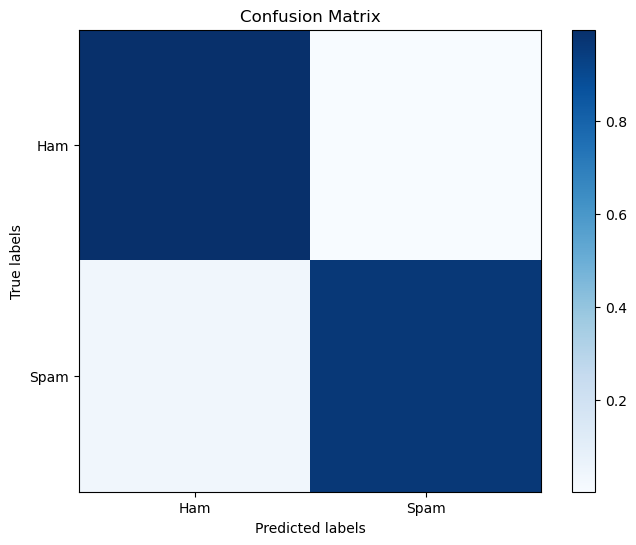

In [273]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_val, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print("\n\n")
# Normalize the confusion matrix
conf_matrix = conf_matrix.astype(float)
row_sums = np.maximum(conf_matrix.sum(axis=1), 1)
conf_matrix /= row_sums[:, np.newaxis]

# Show the normalized confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')  
plt.title('Confusion Matrix')
plt.colorbar()  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam']) 
plt.yticks(ticks=[0, 1], labels=['Ham', 'Spam'])  
plt.show()

**Final Boss: Testing in a totally new database**

It is common practice in machine/deep learning to split the dataset into two subsets: the validation set and the training set. However, it is usually recommended to actually split the dataset into three sets: the training set, the validation set, and the test set. This helps to avoid potential overfitting that can occur with excessive fine-tuning of the model.

In this case, we will take a more intensive approach. Instead of simply creating an additional set, we will use a completely separate dataset. This approach has a few potential issues. Firstly, the new dataset might have a different format. Secondly, it might contain some instances that overlap with the original dataset. To address these concerns, we will clean the text and check for any intersections between the two datasets.

First of all, we load the dataset

In [275]:
path_test = "/home/trancite/Desktop/Spam/archive_2/spam_ham_dataset.csv"
df2 = pd.read_csv(path_test)

df2['text'] = df2['text'].apply(remove_first_word)
cleaner = TextCleaner()
df2['cleaned_mails'] = df2['text'].apply(cleaner.clean)


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   8.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   0.5s
[CV] END ...................

With the dataset cleaned, we evaluate our model on ALL the instances

In [288]:
#here we are deleting the mails that are in both datasets
common_rows = df2.merge(df, how='inner')
df2 = df2[~df2.index.isin(common_rows.index)]
df2.reset_index(drop=True, inplace=True)

In [289]:
X_test = df2['cleaned_mails']
Y_test = np.array(df2['label_num']).astype(int)
predictions_test = voting_clf.predict(X_test)

And now, the moment we've been waiting for: we'll see if our model is just an overfitted machine or if it can actually generalize.

In [290]:
print(classification_report(Y_test, predictions_test))


              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3658
           1       0.87      0.78      0.83      1493

    accuracy                           0.90      5151
   macro avg       0.89      0.87      0.88      5151
weighted avg       0.90      0.90      0.90      5151



This is impressive! Although the performance is slightly worse compared to our previous validation set, which might indicate some overfitting during fine-tuning or shared features in the emails from the other dataset, these results are still outstanding, especially considering that this dataset contains entirely new instances for our model.

Most metrics are close to 0.9, which is excellent. However, there is one slight concern: the recall for the spam label is around 0.78. This "lower" (yet still good) recall suggests that the model occasionally misclassifies spam emails as ham.

Another time, we are going to see the confusion matrix

Confusion Matrix:
[[3489  169]
 [ 321 1172]]
Confusion Matrix:
[[3489  169]
 [ 321 1172]]





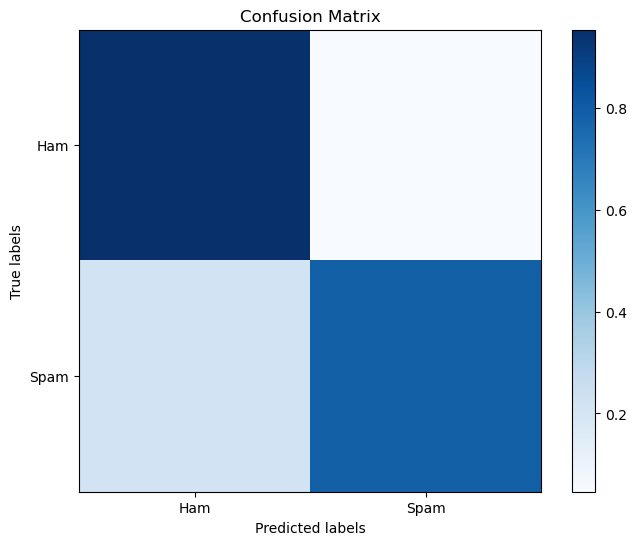

In [304]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, predictions_test)
print("Confusion Matrix:")
print(conf_matrix)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print("\n\n")
# Normalize the confusion matrix
conf_matrix = conf_matrix.astype(float)
row_sums = np.maximum(conf_matrix.sum(axis=1), 1)
conf_matrix /= row_sums[:, np.newaxis]

# Show the normalized confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')  
plt.title('Confusion Matrix')
plt.colorbar()  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam']) 
plt.yticks(ticks=[0, 1], labels=['Ham', 'Spam'])  
plt.show()

And that’s all! Thank you very much for your time, and I welcome any suggestions or comments you may have! If anyone has questions or is interested in collaborating on more deep learning, machine learning, or data science projects, feel free to reach out—my contact info is in my profile!

Y gracias a AM por todo el amor que me das!